## Loading data with chunks

The yt_xarray accessor can loaded gridded data in chunks for some gridded data (at present, fields must be 3D and the grid must be a uniform grid). 

Given an xarray dataset:

In [1]:
from yt_xarray.sample_data import load_random_xr_data
import yt 
import yt_xarray 

fields = {'temperature': ('x', 'y', 'z'), 'pressure': ('x', 'y', 'z')}
dims = {'x': (0,1,15), 'y': (0, 1, 10), 'z': (0, 1, 15)}
ds = load_random_xr_data(fields, dims, length_unit='m')

the `chunksizes` argument to `ds.yt.load_grid` will split the grid into sub-grids, each containing a number of cell sizes equal to `chunksizes` (with extra grids containing any partial chunks): 

In [2]:
yt_ds = ds.yt.load_grid(chunksizes=5)

yt_xarray : [INFO ] 2023-02-06 13:47:37,093:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2023-02-06 13:47:37,095:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 13:47:37,096:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt_xarray : [INFO ] 2023-02-06 13:47:37,096:  Constructing a yt chunked grid with 18 chunks.
yt : [INFO     ] 2023-02-06 13:47:37,188 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 13:47:37,189 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 13:47:37,190 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 13:47:37,191 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 13:47:37,192 Parameters: cosmological_simulation   = 0


Now when yt processes data, it will iterate over the chunks for most functions. The yt grids can be visualized on plot objects with the `annotate_grids` plot callback:

yt : [INFO     ] 2023-02-06 13:47:37,442 xlim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 13:47:37,442 ylim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 13:47:37,443 xlim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 13:47:37,444 ylim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 13:47:37,448 Making a fixed resolution buffer of (('stream', 'temperature')) 800 by 800
/home/chris/.pyenv/versions/3.9.0/envs/yt_xarray/lib/python3.9/site-packages/unyt/array.py:1882: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(



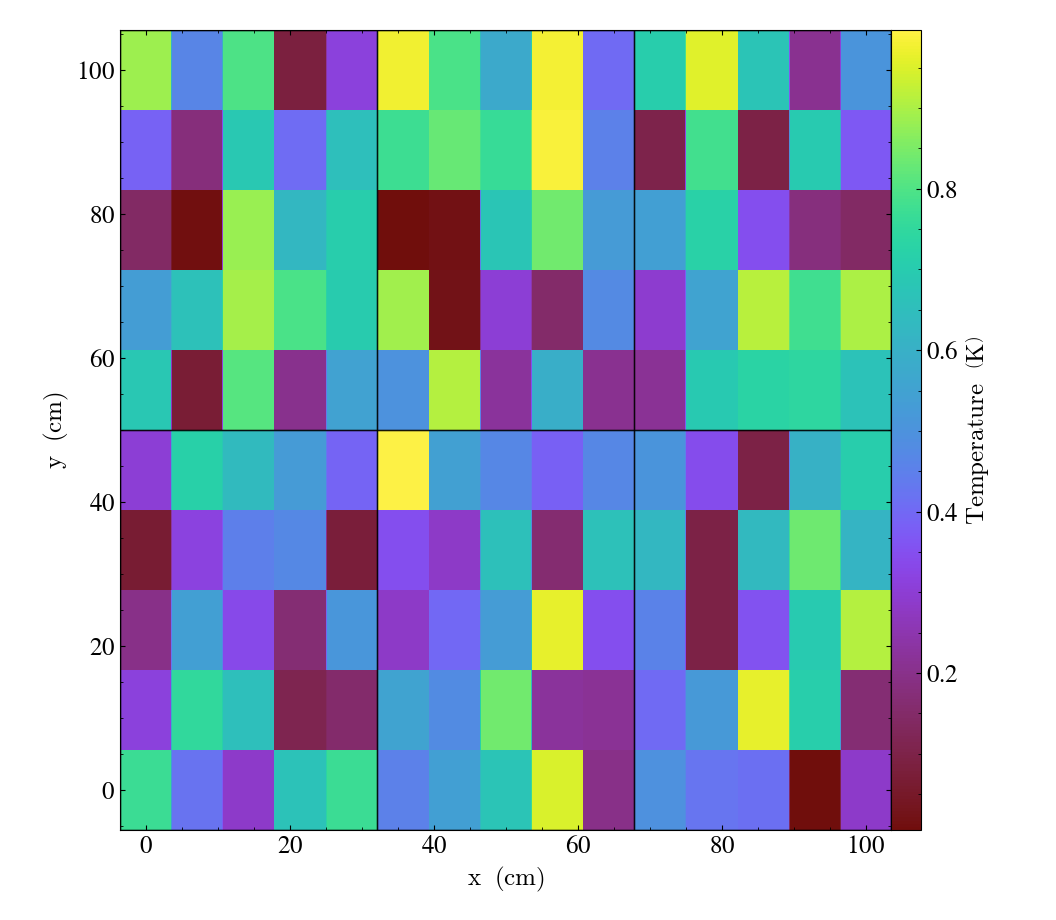

In [3]:
slc = yt.SlicePlot(yt_ds, "z", ("stream", "temperature"), origin="native")
slc.set_log(("stream", "temperature"), False)
slc.annotate_grids()
slc.show()

You can also specify the `chunksizes` argument as a tuple if you want to have different sized chunks in each dimension:

yt_xarray : [INFO ] 2023-02-06 13:47:38,156:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 13:47:38,157:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt_xarray : [INFO ] 2023-02-06 13:47:38,158:  Constructing a yt chunked grid with 96 chunks.
yt : [INFO     ] 2023-02-06 13:47:38,248 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 13:47:38,249 Parameters: domain_dimensions         = [15 10 15]
yt : [INFO     ] 2023-02-06 13:47:38,250 Parameters: domain_left_edge          = [-0.03571429 -0.05555556 -0.03571429]
yt : [INFO     ] 2023-02-06 13:47:38,251 Parameters: domain_right_edge         = [1.03571429 1.05555556 1.03571429]
yt : [INFO     ] 2023-02-06 13:47:38,251 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-02-06 13:47:38,373 xlim = -0.035714 1.035714
yt : [INFO     ] 2023-02-06 13:47:38,374 ylim = -0.055556 1.055556
yt : [INFO     ] 2023-02-06 13:47:38,375 xlim 


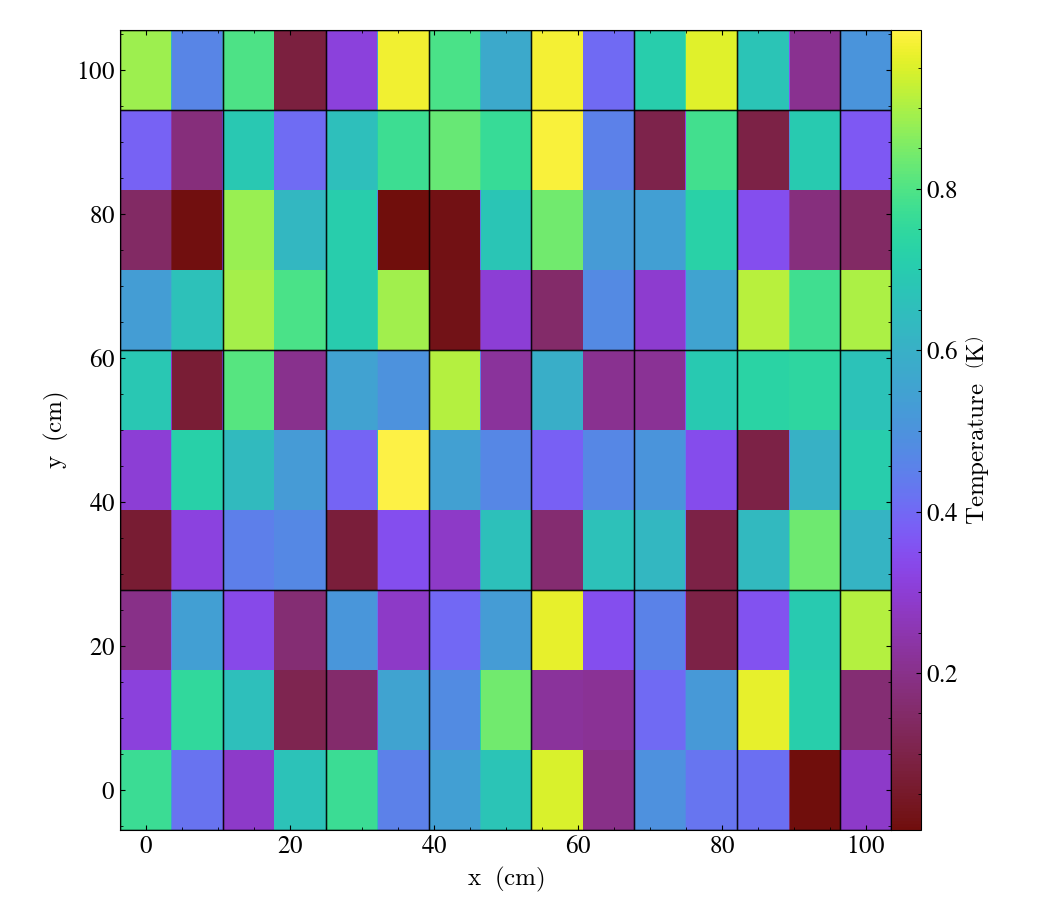

In [4]:
yt_ds = ds.yt.load_grid(chunksizes=(2,3,5))
slc = yt.SlicePlot(yt_ds, "z", ("stream", "temperature"), origin="native")
slc.set_log(("stream", "temperature"), False)
slc.annotate_grids()
slc.show()

## yt_xarray and Dask chunks

While yt_xarray can handle chunked xarray fields, the current implementation does not guarantee alignment between yt and xarray chunks. This means that when using a Dask backend, yt may request index ranges that span dask chunks when operating on yt grid objects. To illustrate this, let's first build an xarray dataset with a single field defined by a dask array:

In [5]:
from dask import array as da
import xarray as xr
import numpy as np 
import yt_xarray 

shp = (800, 650, 500)
f1 = da.random.random(shp , chunks=100)
coords = {'x': np.linspace(0, 1, shp[0]), 
          'y': np.linspace(0, 1, shp[1]), 
          'z': np.linspace(0, 1, shp[2])}

data = {'test_field': xr.DataArray(f1, coords=coords, dims=('x', 'y', 'z'))}
ds = xr.Dataset(data)
ds.test_field

<xarray.DataArray 'test_field' (x: 800, y: 650, z: 500)>
dask.array<random_sample, shape=(800, 650, 500), dtype=float64, chunksize=(100, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.001252 0.002503 0.003755 ... 0.9975 0.9987 1.0
  * y        (y) float64 0.0 0.001541 0.003082 0.004622 ... 0.9969 0.9985 1.0
  * z        (z) float64 0.0 0.002004 0.004008 0.006012 ... 0.996 0.998 1.0

Now when calling `load_grid`, the yt grid objects will contain dask chunks:

In [6]:
yt_ds = ds.yt.load_grid(length_unit='m', chunksizes=100)

yt_xarray : [INFO ] 2023-02-06 13:47:38,993:  Inferred geometry type is cartesian. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2023-02-06 13:47:38,995:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 13:47:38,996:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt_xarray : [INFO ] 2023-02-06 13:47:38,997:  Constructing a yt chunked grid with 280 chunks.
yt : [INFO     ] 2023-02-06 13:47:39,073 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 13:47:39,075 Parameters: domain_dimensions         = [800 650 500]
yt : [INFO     ] 2023-02-06 13:47:39,076 Parameters: domain_left_edge          = [-0.00062578 -0.00077042 -0.001002  ]
yt : [INFO     ] 2023-02-06 13:47:39,077 Parameters: domain_right_edge         = [1.00062578 1.00077042 1.001002  ]
yt : [INFO     ] 2023-02-06 13:47:39,078 Parameters: cosmological_simulation   = 0


Because the chunking division follows the same axis-ordering as xarray and we chose the same chunksize, the resulting yt grids should line up with the dask array chunks:

yt : [INFO     ] 2023-02-06 13:47:39,897 xlim = -0.000626 1.000626
yt : [INFO     ] 2023-02-06 13:47:39,898 ylim = -0.000770 1.000770
yt : [INFO     ] 2023-02-06 13:47:39,899 xlim = -0.000626 1.000626
yt : [INFO     ] 2023-02-06 13:47:39,899 ylim = -0.000770 1.000770
yt : [INFO     ] 2023-02-06 13:47:39,904 Making a fixed resolution buffer of (('stream', 'test_field')) 800 by 800
/home/chris/.pyenv/versions/3.9.0/envs/yt_xarray/lib/python3.9/site-packages/unyt/array.py:1882: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(



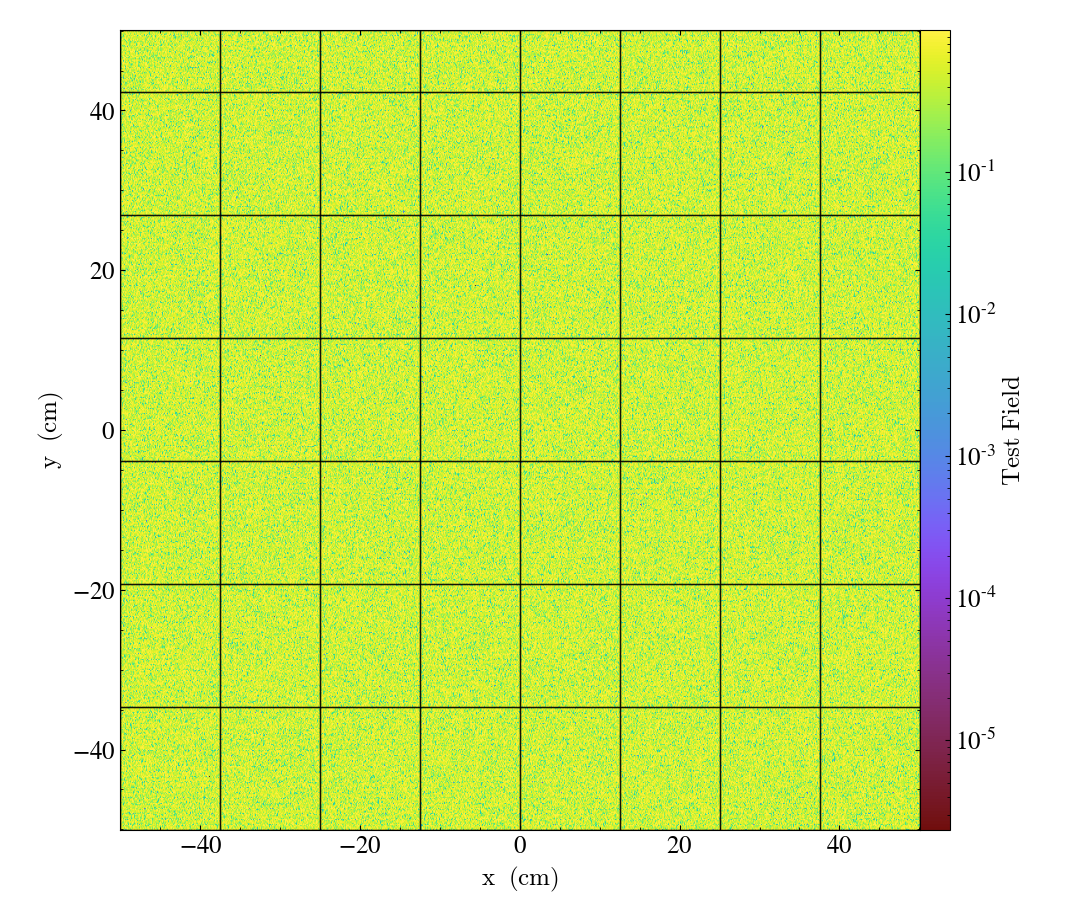

In [7]:
slc = yt.SlicePlot(yt_ds, "z", ("stream", "test_field"))
slc.annotate_grids()
slc.show()

But you can also set the yt grid chunksize independently of the underlying dask chunks. If loading the yt datasets with a chunksize larger than that of the underlying dask array, then multiple dask chunks will be contained within a yt grid:

In [8]:
yt_ds = ds.yt.load_grid(length_unit='m', chunksizes=200)

yt_xarray : [INFO ] 2023-02-06 13:47:41,013:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2023-02-06 13:47:41,013:      Cartesian geometry on uniform grid: yt_xarray will not interpolate.
yt_xarray : [INFO ] 2023-02-06 13:47:41,014:  Constructing a yt chunked grid with 48 chunks.
yt : [INFO     ] 2023-02-06 13:47:41,063 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-02-06 13:47:41,064 Parameters: domain_dimensions         = [800 650 500]
yt : [INFO     ] 2023-02-06 13:47:41,065 Parameters: domain_left_edge          = [-0.00062578 -0.00077042 -0.001002  ]
yt : [INFO     ] 2023-02-06 13:47:41,066 Parameters: domain_right_edge         = [1.00062578 1.00077042 1.001002  ]
yt : [INFO     ] 2023-02-06 13:47:41,067 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2023-02-06 13:47:41,846 xlim = -0.000626 1.000626
yt : [INFO     ] 2023-02-06 13:47:41,847 ylim = -0.000770 1.000770
yt : [INFO     ] 2023-02-06 13:47:41,848 xlim = -0.000626 1.000626
yt : [INFO     ] 2023-02-06 13:47:41,849 ylim = -0.000770 1.000770
yt : [INFO     ] 2023-02-06 13:47:41,857 Making a fixed resolution buffer of (('stream', 'test_field')) 800 by 800
/home/chris/.pyenv/versions/3.9.0/envs/yt_xarray/lib/python3.9/site-packages/unyt/array.py:1882: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(



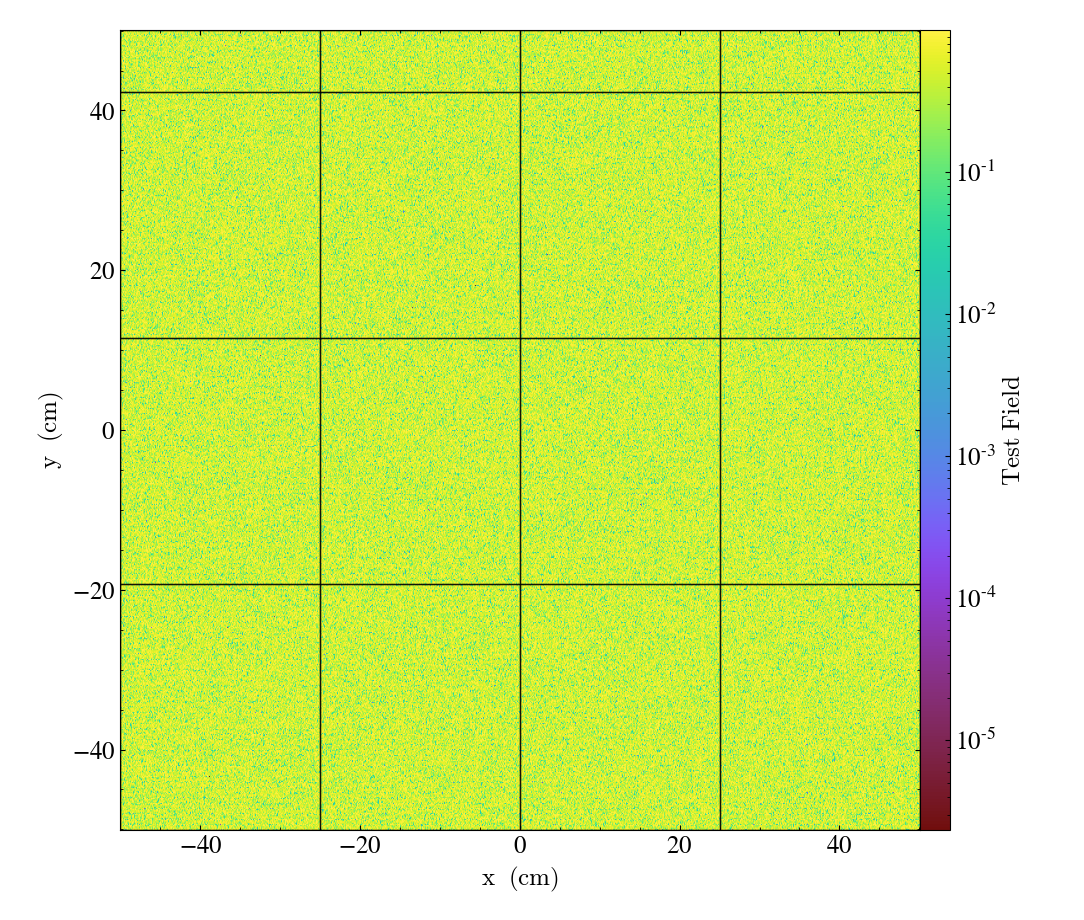

In [9]:
slc = yt.SlicePlot(yt_ds, "z", ("stream", "test_field"))
slc.annotate_grids()
slc.show()

In some cases, the mismatch may lead to memory issues: if you set the yt grids contain multiple dask chunks then those dask chunks need to fit in memory. But there may also be some performance savings by containing multiple dask chunks within a single yt sub-grid.

Work is under way to better sync the xarray-dask chunks with yt grid objects, see [Issue 28](https://github.com/data-exp-lab/yt_xarray/issues/28) for any updates or to get involved!